In [3]:
import flopy
import numpy as np
import matplotlib.pyplot as plt
import shutil
from pathlib import Path
import pandas as pd


from datetime import datetime
from tempfile import TemporaryDirectory
from tempfile import mkdtemp

import os
import platform
import subprocess
#from shapely.geometry import Polygon, Point
#from scipy.interpolate import make_interp_spline



In [4]:
def open_file(path):
    if platform.system() == "Windows":
        os.startfile(path)
    elif platform.system() == "Darwin":
        subprocess.Popen(["open", path])
    else:
        subprocess.Popen(["xdg-open", path])

# Plot Results

In [ ]:

model_ws =  Path('H:/mf/_T0208024128__Cowardly_Bird')  
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [ ]:
model_ws =  Path('H:/mf/_T0212022329__Brave_Chair')  
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [3]:


model_ws =  Path('H:/mf/_T0212235115__Thin_Map')   # 1000 years model
model_ws =  Path('/Volumes/Expansion/mf/_T0212235115__Thin_Map')   # 1000 years model
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [5]:


model_ws =  Path('H:/mf/_T0221015710__Easy_Necklace')   # 4000 years model

#model_ws =  Path('/Volumes/Expansion/mf/_T0221015710__Easy_Necklace')   
model_ws =  Path('/Volumes/Expansion/mf/_T0317031619__Wide_Clock')   
model_ws =  Path('F:/mf/_T0317031619__Wide_Clock')   
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

In [268]:




model_ws =  Path('/Volumes/Expansion/mf/_T0322235809__Radiant_Key') # 1000 years
model = flopy.modflow.Modflow.load('example_model.nam', model_ws=model_ws)

# DIS

In [6]:
dis = model.dis
nrow = dis.nrow
ncol = dis.ncol
nlay = dis.nlay

delr = 2200/nrow
delc = 2200/ncol
layer_thickness = 30/nlay
nper = model.dis.nper

# Read Pickle

In [7]:
import pickle
filename = model_ws/'_output'/'saved_variables.pkl'

# Open the file in binary-read mode and load the data
with open(filename, 'rb') as file:
    data_loaded = pickle.load(file)

# Extracting individual variables from the loaded data
totalPhosphorusDischargeMGPerDay = data_loaded["totalPhosphorusDischargeMGPerDay"]
lakeDischargeM3PerDay = data_loaded["lakeDischargeM3PerDay"]
timeIndices = data_loaded["timeIndices"]
totalPhosphorusDischargeGPerDay = data_loaded["totalPhosphorusDischargeGPerDay"]
SRPMassInSystem_x = data_loaded["SRPMassInSystem_x"]
SRPMassInSystem_y = data_loaded["SRPMassInSystem_y" ]
SRPMassInSystem_aq_y = data_loaded["SRPMassInSystem_aq_y"]
SRPMassInSystem_s_y = data_loaded["SRPMassInSystem_s_y"]
totalPhosphorusDischargeMGPerDay_zoneTotal = data_loaded['totalPhosphorusDischargeMGPerDay_zoneTotal']
totalPhosphorusDischargePerRow = data_loaded['totalPhosphorusDischargePerRow']

# Cross-section


## hds

In [10]:
### SLOW ### SLOW ### SLOW ###
headobj = flopy.utils.binaryfile.HeadFile(model_ws / 'example_model.hds')


In [256]:

# Constants
shoreline_distance = 1600
column_idx = 146

# Load data
hds = headobj
times = hds.get_times()
kstpkpers = hds.get_kstpkper()
ibd = model.bas6.ibound.array

# Prepare output directory
output_folder = model_ws / '_output' / 'hds'
output_folder.mkdir(parents=True, exist_ok=True)

# Plot settings
contour_levels = np.arange(164, 188, 0.5)
vmin, vmax = 164, 188

for idx, (timestep, stress_period) in enumerate(kstpkpers[::100]):
    # Prepare data
    head_data = hds.get_data(kstpkper=(timestep, stress_period))
    head_data[head_data == 1e30] = np.nan
    masked_head_data = np.ma.masked_where(ibd == 0, head_data)
    column_data = masked_head_data[:, :, column_idx]

    # Plot
    fig, ax = plt.subplots(figsize=(15, 5))
    X, Y = np.meshgrid(np.arange(column_data.shape[1]), -np.arange(column_data.shape[0]))
    cs = ax.pcolormesh(X, Y, column_data, cmap="viridis", vmin=vmin, vmax=vmax)
    plt.colorbar(cs, ax=ax)
    ax.contour(X, Y, column_data, levels=contour_levels, colors="black", alpha=0.4)
    
    ax.set(xlabel='Row Index', ylabel='Layer Index ', title=f'Year: {int(times[idx] / 365)}')
    ax.text(1700, 185, 'Shoreline', ha='center', va='bottom', fontsize=12)
    plt.axvline(x = 1600/delr)

    # Save figure
    plt.savefig(output_folder / f'hds_{stress_period}_{timestep}_year{int(times[idx] / 365)}.png')
    plt.close(fig)


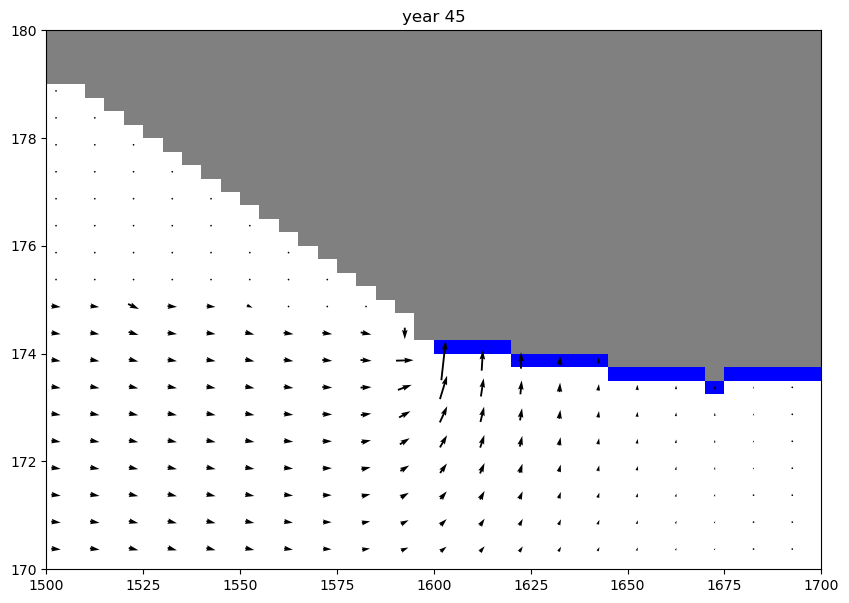

In [266]:
# Get flow data for the last stress period
# Assuming 'nper' is the number of stress periods in your model
last_stress_period = 45

frf = cbc.get_data(text="FLOW RIGHT FACE", kstpkper=(0, last_stress_period))[0]
fff = cbc.get_data(text="FLOW FRONT FACE", kstpkper=(0, last_stress_period))[0]
flf = cbc.get_data(text="FLOW LOWER FACE", kstpkper=(0, last_stress_period))[0]  # Vertical flow component
# Define the cross-section (column view) at column=110
xsect = flopy.plot.PlotCrossSection(model=model, line={'Column': 220})
# Plot flow vectors, including vertical flow

ibd = xsect.plot_ibound(color_noflow='grey')
vc = xsect.plot_vector( frf,-fff, -flf,kstep=2,hstep=2,normalize=False)

plt.title('year {}'.format(last_stress_period))

plt.xlim(1500,1700)
plt.ylim(170,180)
plt.gcf().set_size_inches(10,7)

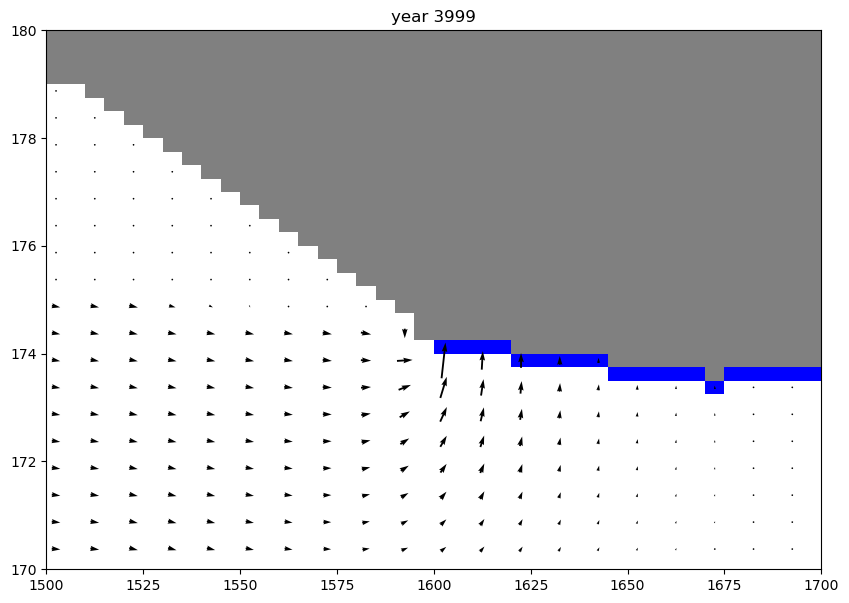

In [267]:
# Get flow data for the last stress period
# Assuming 'nper' is the number of stress periods in your model
last_stress_period = model.dis.nper - 1

frf = cbc.get_data(text="FLOW RIGHT FACE", kstpkper=(0, last_stress_period))[0]
fff = cbc.get_data(text="FLOW FRONT FACE", kstpkper=(0, last_stress_period))[0]
flf = cbc.get_data(text="FLOW LOWER FACE", kstpkper=(0, last_stress_period))[0]  # Vertical flow component
# Define the cross-section (column view) at column=110
xsect = flopy.plot.PlotCrossSection(model=model, line={'Column': 220})
# Plot flow vectors, including vertical flow

ibd = xsect.plot_ibound(color_noflow='grey')
vc = xsect.plot_vector( frf,-fff, -flf,kstep=2,hstep=2,normalize=False)

plt.title('year {}'.format(last_stress_period))

plt.xlim(1500,1700)
plt.ylim(170,180)
plt.gcf().set_size_inches(10,7)

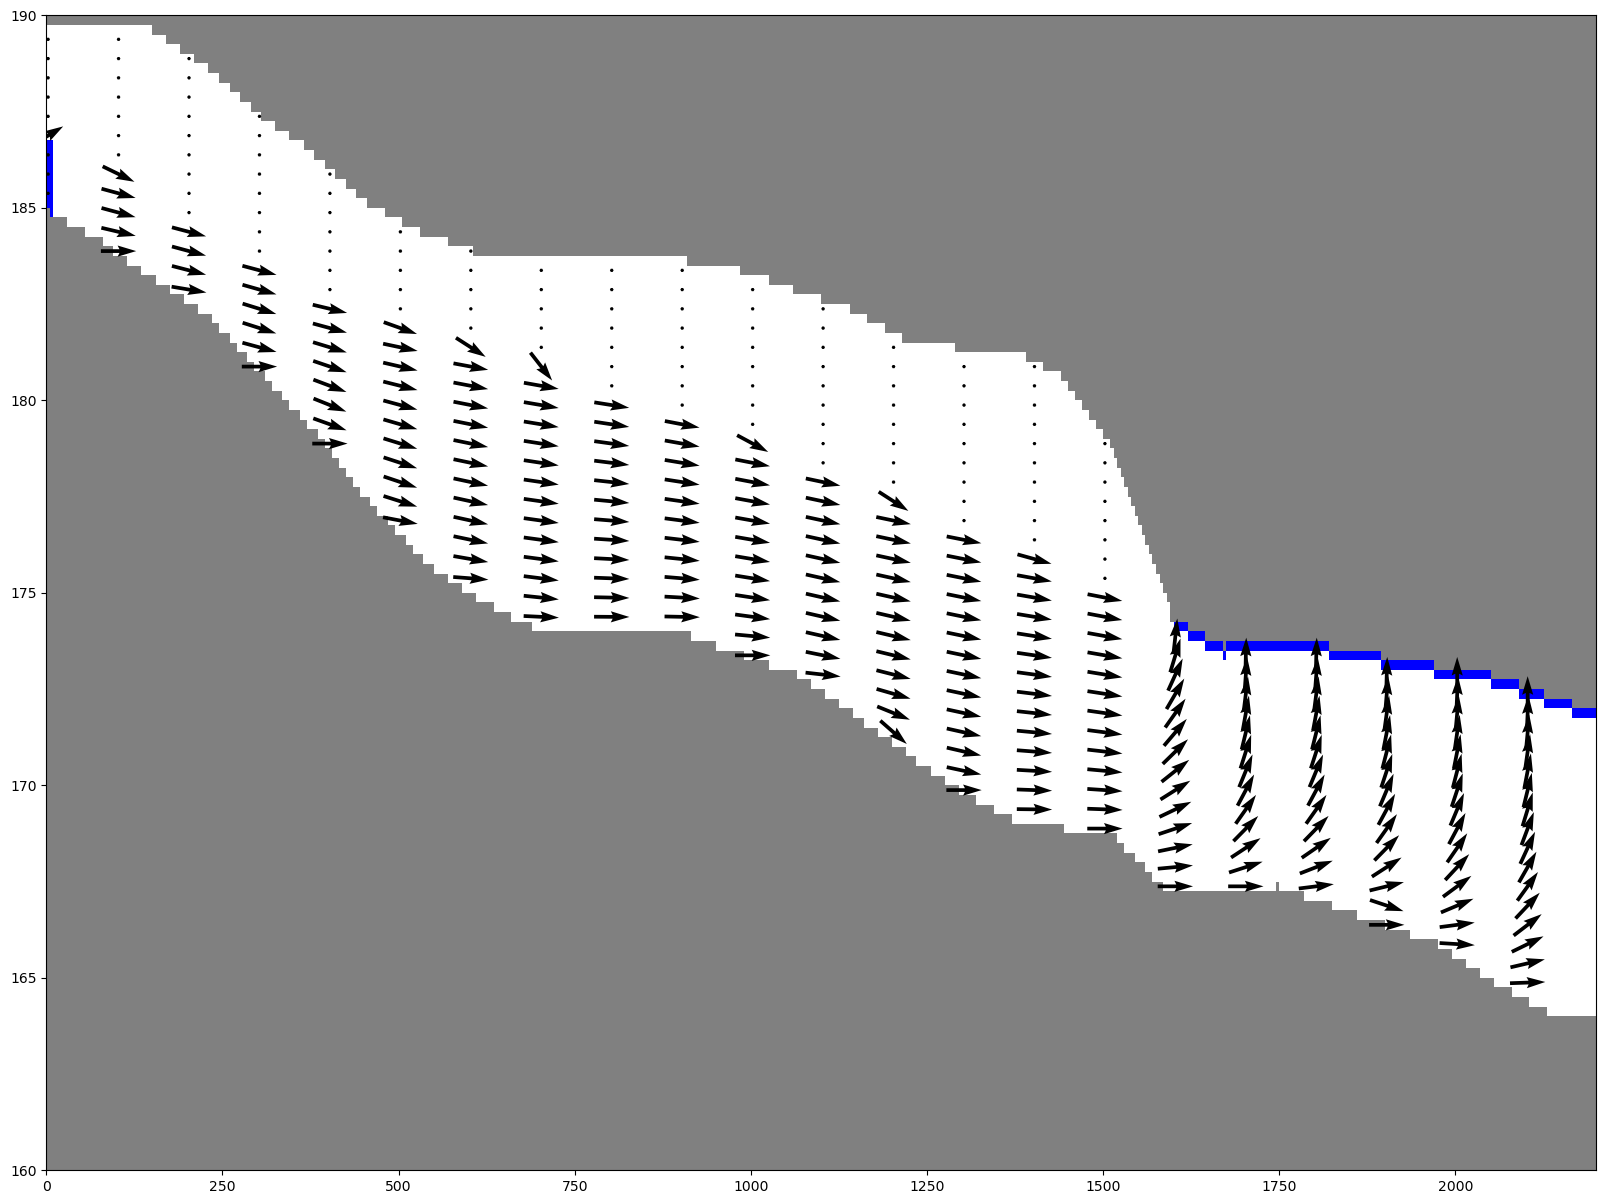

In [257]:
# Get flow data for the last stress period
# Assuming 'nper' is the number of stress periods in your model
last_stress_period = model.dis.nper - 1

frf = cbc.get_data(text="FLOW RIGHT FACE", kstpkper=(0, last_stress_period))[0]
fff = cbc.get_data(text="FLOW FRONT FACE", kstpkper=(0, last_stress_period))[0]
flf = cbc.get_data(text="FLOW LOWER FACE", kstpkper=(0, last_stress_period))[0]  # Vertical flow component
# Define the cross-section (column view) at column=110
xsect = flopy.plot.PlotCrossSection(model=model, line={'Column': 220})
# Plot flow vectors, including vertical flow

ibd = xsect.plot_ibound(color_noflow='grey')
vc = xsect.plot_vector( frf,-fff, -flf,kstep=2,hstep=20,normalize=True)


plt.gcf().set_size_inches(20,15)
plt.show()

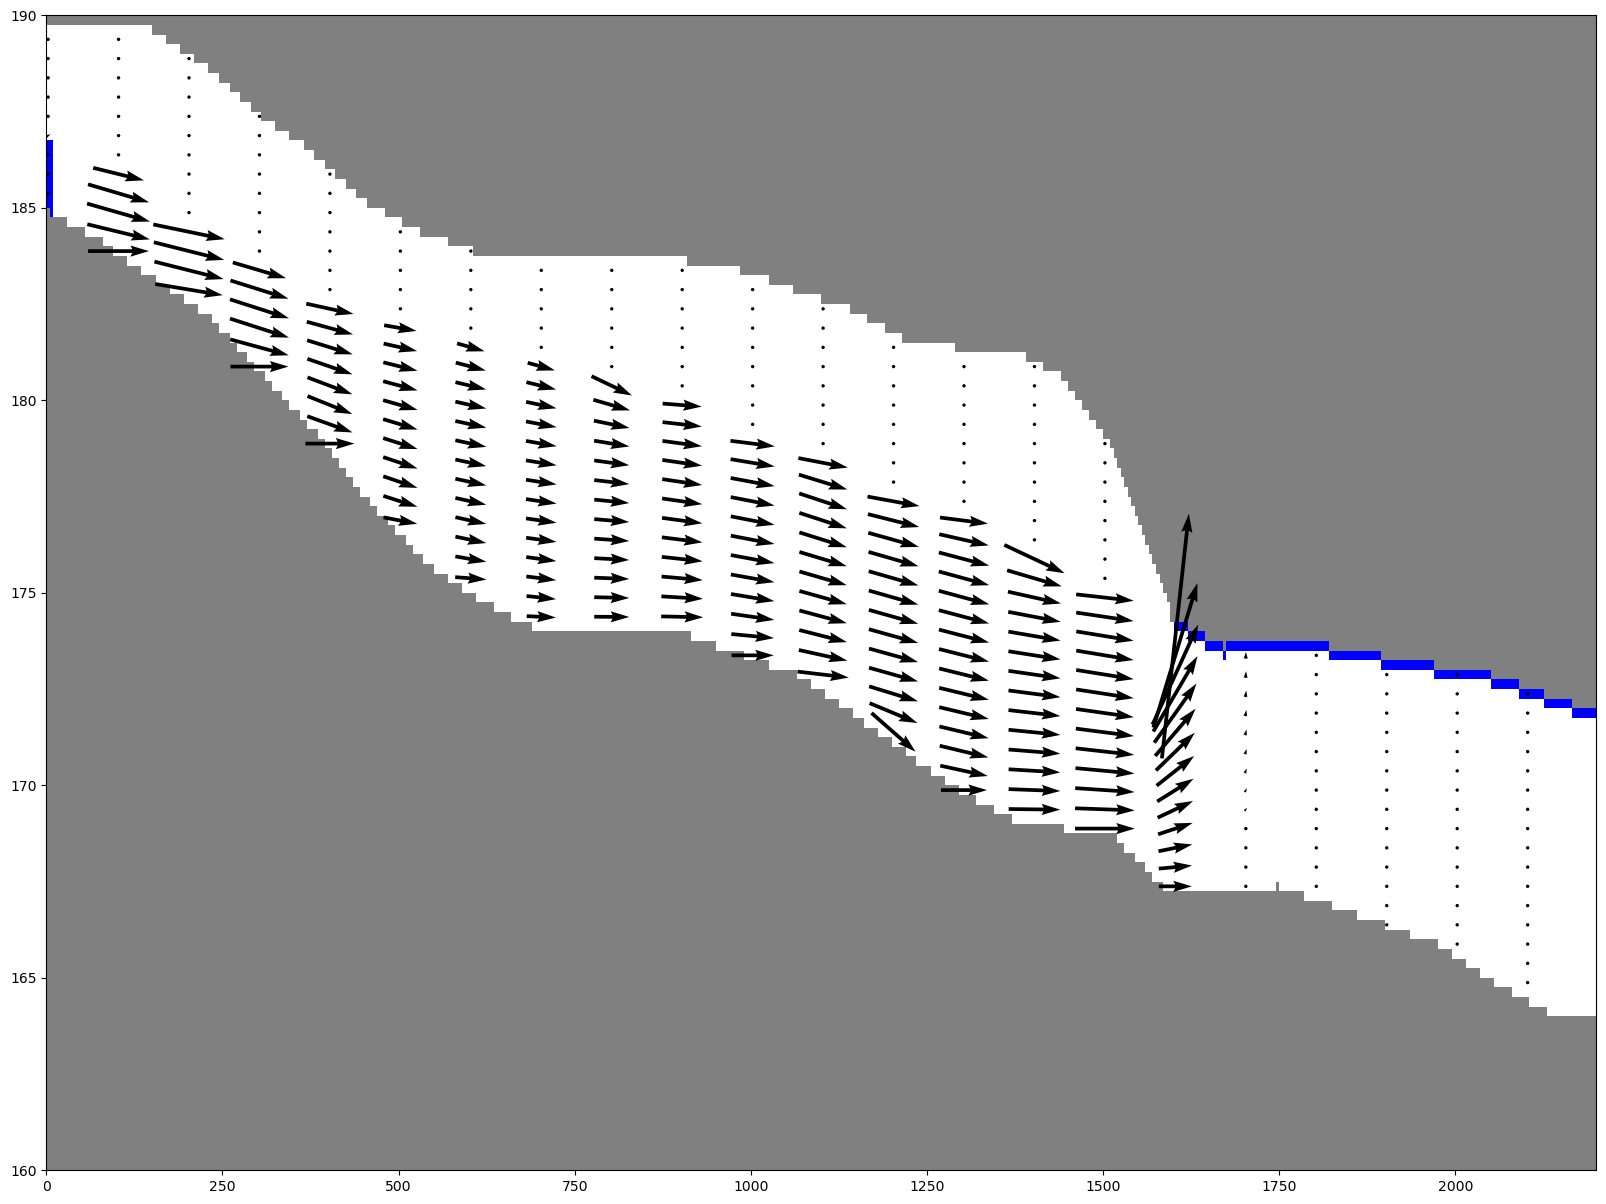

In [254]:
# Get flow data for the last stress period
# Assuming 'nper' is the number of stress periods in your model
last_stress_period =30
frf = cbc.get_data(text="FLOW RIGHT FACE", kstpkper=(0, last_stress_period))[0]
fff = cbc.get_data(text="FLOW FRONT FACE", kstpkper=(0, last_stress_period))[0]
flf = cbc.get_data(text="FLOW LOWER FACE", kstpkper=(0, last_stress_period))[0]  # Vertical flow component
# Define the cross-section (column view) at column=110
xsect = flopy.plot.PlotCrossSection(model=model, line={'Column': 220})

# Plot flow vectors, including vertical flow
ibd = xsect.plot_ibound(color_noflow='grey')
xsect.plot_vector( frf,-fff, -flf,kstep=2,hstep=20,normalize=False)

plt.gcf().set_size_inches(20,15)
plt.show()

## SRP

In [11]:
### SLOW ### SLOW ### SLOW ###

ibound = model.bas6.ibound.array
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

ValueError: datafile error: file is empty: F:\mf\_T0317031619__Wide_Clock\MT3D001.UCN

In [ ]:
### SLOW ### SLOW ### SLOW ###

ucnobj_s = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001S.UCN')

In [9]:
### read data

col = int(ncol/3)
col = 146
# ibound = model.bas6.ibound.array
# ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

# for kper in range(nper):
for kper in [55]:
    # Read the concentration data from the UCN file
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    # Mask the inactive cells
    mask = ((ibound== 0)|(concentration_array>=1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    ### plotting# #######
    fig = plt.figure(figsize=(15, 4))
    line = {"Column": col}

    # Create a PlotCrossSection object for the model
    xsect = flopy.plot.PlotCrossSection(model=model, line=line)

    # Plot the concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=500)
    plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    plt.title('col:{:03}, kper:{:02}'.format(col,kper))
    plt.savefig(Path(model_ws)/'_output/conc_{:02}.png'.format(kper))
    plt.clf()

##--------

<Figure size 1500x400 with 0 Axes>

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import cv2

# Set parameters
col = 25
# ibound = model.bas6.ibound.array
# ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')
output_dir = Path(model_ws) / '_output' / 'conc_xsec'
output_dir.mkdir(parents=True, exist_ok=True)  # Ensure the output directory exists

nrow = ibound.shape[1]  # Assuming ibound shape is (nlay, nrow, ncol)
shoreline_distance = 100  # Set to your shoreline distance
delr = 1  # Set to your grid spacing in the row direction
vertical_line_position = nrow - int(shoreline_distance / delr)

# Retrieve times and stress periods
times = ucnobj.get_times()  # list of times
kstpkpers = ucnobj.get_kstpkper()  # list of (kstp, kper) tuples

for kstp, kper in kstpkpers[300:400]:
    year = round((times[kper] / 365) - 1 + 1950, 1)
    conc_col = ucnobj.get_data(kstpkper=(kstp, kper))[:, :, col]
    mask = (ibound[:, :, col] == 0) | (conc_col >= 1e30)
    masked_conc_col = np.ma.masked_where(mask, conc_col)
    
    fig, ax = plt.subplots(figsize=(15, 4))
    cax = ax.imshow(masked_conc_col, cmap='coolwarm', vmin=0.1, vmax=100, origin='lower', aspect='auto')
    plt.colorbar(cax, ax=ax)
    ax.axvline(x=vertical_line_position, color='k', linestyle='--')
    ax.set_title(f'XSec Column: {col}, Stress Period: {kper}, Year: {year}')
    ax.set_xlabel('Cells [row]')
    ax.set_ylabel('Cells [layer]')
    ax.invert_yaxis()
    
    image_path = output_dir / f'xsec_col_{col}_{kper:02}.png'
    plt.savefig(image_path)
    plt.close(fig)

# Video creation
frame = cv2.imread(str(image_path))
height, width, layers = frame.shape
video = cv2.VideoWriter(str(output_dir / f'xsec_col_{col}_video.mp4'), cv2.VideoWriter_fourcc(*'mp4v'), 10, (width,height))

for image_path in output_dir.glob('xsec_col_{}_*.png'.format(col)):
    video.write(cv2.imread(str(image_path)))

video.release()
cv2.destroyAllWindows()


ImportError: DLL load failed while importing cv2: The specified module could not be found.

In [328]:
target_times

[3650.0, 18250.0, 36500.0, 146000.0, 255500.0, 365000.0, 730000.0, 1460000.0]

In [332]:
import numpy as np
import matplotlib.pyplot as plt
import flopy
from pathlib import Path

# Constants and initial setup
col = int(ncol / 3)  # Assuming `ncol` is defined elsewhere and is the number of columns in the model grid

#delr = ...  # Cell width along rows, define this based on your model's discretization
output_dir = Path(model_ws) / f'_output/xsect_col_{col:03}'
output_dir.mkdir(parents=True, exist_ok=True)  # Using pathlib for directory creation

times = ucnobj.get_times()  # list of times
kstpkpers = ucnobj.get_kstpkper()  # list of (kstp, kper) tuples
shoreline_distance = 1600

for kstp, kper in kstpkpers[1:-1:100]:  # Loop through specified timesteps and stress periods
    
    # Load and mask concentration data
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))
    concentration_array[concentration_array >= 1e30] = np.nan  # Handle large values as NaN
    masked_conc_data = np.ma.masked_where(ibound == 0, concentration_array)  # Mask inactive cells
    
    # Extract column data
    column_data = masked_conc_data[:, :, col]  # Assuming 3D data; adjust the slicing as necessary

    # Adjust X to represent actual distances using delr
    x_distances = np.arange(0, column_data.shape[1] * delr, delr)
    y_indices = -np.arange(column_data.shape[0])  # Assuming negative for vertical axis; adjust as needed

    # Plot
    fig, ax = plt.subplots(figsize=(8, 4))
    X, Y = np.meshgrid(x_distances, y_indices)
    cs = ax.pcolormesh(X, Y, column_data, cmap='coolwarm', vmin=0.1, vmax=300)
    plt.colorbar(cs, ax=ax)
    ax.axvline(x=shoreline_distance, color='k')  # Ensure shoreline_distance is defined

    # Set plot titles and labels as needed
    ax.set_title(f'Column: {col}, Stress Period: {kper}, Timestep: {kstp}')
    ax.set_xlabel('Distance (m)')  # Adjust label as necessary
    ax.set_ylabel('Layer Index')  # Adjust label as necessary
    
    # Save the figure
    plt.savefig(output_dir / f'conc_{kper:02}_{kstp:02}.png')
    plt.close(fig)  # Close the figure to free memory

In [348]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Constants and initial setup
col = int(ncol / 3)  # Assuming `ncol` is defined elsewhere and is the number of columns in the model grid

#delr = ...  # Cell width along rows, define this based on your model's discretization
output_dir = Path(model_ws) / f'_output/xsect_col_{col:03}'
output_dir.mkdir(parents=True, exist_ok=True)  # Using pathlib for directory creation

times = ucnobj.get_times()  # list of times
kstpkpers = ucnobj.get_kstpkper()  # list of (kstp, kper) tuples
shoreline_distance = 1600

# Find indices in `times` that match the specified times
specified_times = [365*10, 365*50, 365*100,365*400,365*700,365*1000,365*2000,365*4000]
time_indices = [i for i, time in enumerate(times) if time in specified_times]

image_files = []

for idx in time_indices:
    kstp, kper = kstpkpers[idx]  # Get (kstp, kper) for the current time
    
    # Load and mask concentration data
    concentration_array = ucnobj.get_data(kstpkper=(kstp, kper))
    concentration_array[concentration_array >= 1e30] = np.nan  # Handle large values as NaN
    masked_conc_data = np.ma.masked_where(ibound == 0, concentration_array)  # Mask inactive cells
    
    # Extract column data
    column_data = masked_conc_data[:, :, col]  # Assuming 3D data; adjust the slicing as necessary

    # Adjust X to represent actual distances using delr
    x_distances = np.arange(0, column_data.shape[1] * delr, delr)
    y_indices = -np.arange(column_data.shape[0])  # Assuming negative for vertical axis; adjust as needed

    # Plot
    fig, ax = plt.subplots(figsize=(5, 3))
    X, Y = np.meshgrid(x_distances, y_indices)
    cs = ax.pcolormesh(X, Y, column_data, cmap='coolwarm', vmin=0.1, vmax=300)
    plt.colorbar(cs, ax=ax)
    ax.axvline(x=shoreline_distance, color='k')  # Ensure shoreline_distance is defined

    # Set plot titles and labels as needed
    #ax.set_title(f'Column: {col}, Stress Period: {kper}, Timestep: {kstp}, Time: {times[idx]}')
    ax.set_xlabel('Cross-shore Distance (m)')  # Adjust label as necessary
    #ax.set_ylabel('Layer Index')  # Adjust label as necessary
    ax.set_yticks([])
    plt.tight_layout()
    # Save the figure
    output_file = output_folder / f'conc_{kper:02}_{kstp:02}_{times[idx]}.png'
    plt.savefig(output_file)
    
    plt.close(fig)  # Close the figure to free memory
    image_files.append(output_file)




from PIL import Image

# Assuming 'image_files' is a list of 8 image file paths
if len(image_files) == 8:
    # Load all images
    images = [Image.open(x) for x in image_files]

    # Assuming all images are of the same size, get width and height of the first image
    width, height = images[0].size

    # Calculate total width and total height for the 4x2 grid
    total_width = width * 2
    total_height = height * 4

    # Create a new blank image with the calculated size
    new_im = Image.new('RGB', (total_width, total_height))

    # Paste images into the new image
    y_offset = 0
    for i in range(4):  # Four rows
        x_offset = 0
        for j in range(2):  # Two columns
            # Calculate the index of the current image
            index = i * 2 + j
            # Paste the current image into the new image
            new_im.paste(images[index], (x_offset, y_offset))
            # Move to the next column
            x_offset += width
        # Move to the next row
        y_offset += height

    # Save the new mosaic image
    mosaic_file = output_dir / 'concentration_maps_mosaic_4x2.png'
    new_im.save(mosaic_file)
else:
    print("The number of generated images does not match the expected 4x2 grid layout.")


In [345]:
width

600

In [125]:
#Solid Phase

# Constants and initial setup
col = int(ncol / 3)  # Assuming `ncol` is defined elsewhere and is the number of columns in the model grid
col = int(100/5)
#delr = ...  # Cell width along rows, define this based on your model's discretization
output_dir = Path(model_ws) / f'_output/s_xsect_col_{col:03}'
output_dir.mkdir(parents=True, exist_ok=True)  # Using pathlib for directory creation

times = ucnobj_s.get_times()  # list of times
kstpkpers = ucnobj_s.get_kstpkper()  # list of (kstp, kper) tuples
shoreline_distance = 1600


for kstp, kper in kstpkpers[0:-1:10]:  # Loop through specified timesteps and stress periods
    
    # Load and mask concentration data
    concentration_array = ucnobj_s.get_data(kstpkper=(0, kper))
    concentration_array[concentration_array >= 1e30] = np.nan  # Handle large values as NaN
    masked_conc_data = np.ma.masked_where(ibound == 0, concentration_array)  # Mask inactive cells
    
    # Extract column data
    column_data = masked_conc_data[:, :, col]  # Assuming 3D data; adjust the slicing as necessary

    # Adjust X to represent actual distances using delr
    x_distances = np.arange(0, column_data.shape[1] * delr, delr)
    y_indices = -np.arange(column_data.shape[0])  # Assuming negative for vertical axis; adjust as needed

    # Plot
    fig, ax = plt.subplots(figsize=(15, 4))
    X, Y = np.meshgrid(x_distances, y_indices)
    cs = ax.pcolormesh(X, Y, column_data, cmap='coolwarm')
    plt.colorbar(cs, ax=ax)
    ax.axvline(x=shoreline_distance, color='k')  # Ensure shoreline_distance is defined

    # Set plot titles and labels as needed
    ax.set_title(f'Column: {col}, Stress Period: {kper}, Timestep: {kstp}')
    ax.set_xlabel('Distance (m)')  # Adjust label as necessary
    ax.set_ylabel('Layer Index')  # Adjust label as necessary
    
    # Save the figure
    plt.savefig(output_dir / f'conc_{kper:02}_{kstp:02}.png')
    plt.close(fig)  # Close the figure to free memory


In [104]:
kstpkpers[5]

(0, 2)

In [ ]:
### close up image

col = int(ncol/3)

# for kper in range(nper):
for kper in [999]:
    # Read the concentration data from the UCN file
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    # Mask the inactive cells
    mask = ((ibound== 0)|(concentration_array>=1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    ### plotting# #######
    fig = plt.figure(figsize=(15, 4))
    line = {"Column": col}

    # Create a PlotCrossSection object for the model
    xsect = flopy.plot.PlotCrossSection(model=model, line=line)

    # Plot the concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=200)
    plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    plt.title('col:{:03}, kper:{:02}'.format(col,kper))
    # plt.xlim(1600,1750)
    # plt.ylim(165,180)

    plt.axvline(x=shoreline_distance, color='k') #source
    #plt.savefig(Path(model_ws)/'_output/conc_{:02}.png'.format(kper))
    #plt.clf()

##--------

## Row View Xsect

In [ ]:
### read data

#col = int(ncol/3)
row =  int((1700-70+20+20+20)/(delc))
# ibound = model.bas6.ibound.array
# ucnobj = flopy.utils.binaryfile.UcnFile(model_ws / 'MT3D001.UCN')

# for kper in range(nper):
for kper in [99]:
    # Read the concentration data from the UCN file
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

    # Mask the inactive cells
    mask = ((ibound== 0)|(concentration_array>=1e30))
    masked_conc_data = np.ma.masked_where(mask, concentration_array)

    ### plotting# #######
    fig = plt.figure(figsize=(15, 4))
    line = {"Row": row}

    # Create a PlotCrossSection object for the model
    xsect = flopy.plot.PlotCrossSection(model=model, line=line)

    # Plot the concentration results
    cs = xsect.plot_array(masked_conc_data, cmap='coolwarm', vmin=0.1, vmax=300)
    plt.colorbar(cs)
    ibd = xsect.plot_ibound(color_noflow='grey')
    #plt.title('roz
    plt.savefig(Path(model_ws)/'_output/conc_rowview_row{:02}_{:02}.png'.format(row,kper))
    
    plt.clf()

##--------

# GW Budget

In [8]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [9]:
# cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)

# times = cbc.get_times()
# fff = cbc.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]
# frf = cbc.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]
# flf = cbc.get_data(text='FLOW LOWER FACE', totim=times[-1])[0]
# faf = flf + fff + frf

In [10]:

#ch  = cbc.get_data(text='CONSTANT HEAD', totim=times[0])[0]


In [ ]:
cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)

In [12]:
### SLOW ### SLOW ### SLOW ###

#cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)
cellBudgetFile = cbc
concentrationFile = ucnobj

timeSteps = cellBudgetFile.get_times()
timeIndices = []
lakeDischargeM3PerDay = []
totalPhosphorusDischargeMGPerDay = []

for timeIndex in range(len(timeSteps)):
    print(timeIndex)
    concentrationData = concentrationFile.get_data(totim=timeSteps[timeIndex])
    concentrationData[concentrationData == 1e30] = 0  # Replace no-data values with 0

    constantHeadData = cellBudgetFile.get_data(text='CONSTANT HEAD', totim=timeSteps[timeIndex])[0]
    constantHeadCellIndices = [(np.unravel_index(cellIndex[0], (nlay, nrow, ncol)), cellIndex[1]) for cellIndex in constantHeadData]
    lakeCells = [cell for cell in constantHeadCellIndices if cell[0][1] > float(2200 / 2 / delr)]  # Filtering lake cells based on condition

    lakeDischargeM3PerDay.append(np.sum([cell[1] for cell in lakeCells]))
    totalPhosphorusDischargeMGPerDay.append(np.sum([concentrationData[cell[0]] * cell[1] for cell in lakeCells]))
    timeIndices.append(timeIndex)


totalPhosphorusDischargeGPerDay = np.array(totalPhosphorusDischargeMGPerDay)/1000
print('done')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
#cbc = flopy.utils.CellBudgetFile(model_ws /'example_model.cbc', model=model)
cellBudgetFile = cbc
concentrationFile = ucnobj

timeSteps = cellBudgetFile.get_times()[:]

# Initialize arrays for each zone
totalPhosphorusDischargeMGPerDay_zoneTotal = []
totalPhosphorusDischargeMGPerDay_zone1 = []
totalPhosphorusDischargeMGPerDay_zone2 = []
totalPhosphorusDischargeMGPerDay_zone3 = []
totalPhosphorusDischargeMGPerDay_zone4 = []
totalPhosphorusDischargeMGPerDay_zone5 = []


for timeIndex in range(len(timeSteps)):
    print(timeIndex)
    concentrationData = concentrationFile.get_data(totim=timeSteps[timeIndex])
    concentrationData[concentrationData == 1e30] = 0  # Replace no-data values with 0

    constantHeadData = cellBudgetFile.get_data(text='CONSTANT HEAD', totim=timeSteps[timeIndex])[0]
    constantHeadCellIndices = [(np.unravel_index(cellIndex[0], (nlay, nrow, ncol)), cellIndex[1]) for cellIndex in constantHeadData]

    # Initialize sums for each zone for the current timestep
    zoneTotal_sum = 0 
    zone1_sum = 0
    zone2_sum = 0
    zone3_sum = 0
    zone4_sum = 0
    zone5_sum = 0
    #[0,10,25,50,100,150]
    #[1600-1602, 1602-1605,1605-1610, 1610-1620, 1620-1630]
    
    for cell in constantHeadCellIndices:
        _, row, _ = cell[0]  # Get the row index of the current cell
        zoneTotal_sum  += concentrationData[cell[0]] * cell[1]
        # Check if the cell is within the specified ranges for each zone and sum the values
        if 1600/delr <= row < 1602/delr:
            zone1_sum += concentrationData[cell[0]] * cell[1]
        elif 1602/delr<= row < 1605/delr:
            zone2_sum += concentrationData[cell[0]] * cell[1]
        elif 1605/delr <= row < 1610/delr:
            zone3_sum += concentrationData[cell[0]] * cell[1]

        elif 1610/delr <= row < 1620/delr:
            zone4_sum += concentrationData[cell[0]] * cell[1]
        elif 1620/delr <= row < 1630/delr:
            zone5_sum += concentrationData[cell[0]] * cell[1]

    # Append the sums to the respective arrays
    totalPhosphorusDischargeMGPerDay_zoneTotal.append(zoneTotal_sum)
    totalPhosphorusDischargeMGPerDay_zone1.append(zone1_sum)
    totalPhosphorusDischargeMGPerDay_zone2.append(zone2_sum)
    totalPhosphorusDischargeMGPerDay_zone3.append(zone3_sum)
    totalPhosphorusDischargeMGPerDay_zone4.append(zone4_sum)
    totalPhosphorusDischargeMGPerDay_zone5.append(zone5_sum)

print('done')


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [110]:
cellBudgetFile = cbc
concentrationFile = ucnobj

timeSteps = cellBudgetFile.get_times()[:]

# Initialization
n_timesteps = len(timeSteps)

n_rows = nrow  # Assuming nrow is the number of rows in your grid

# Create a 2D NumPy array initialized with zeros
# Rows correspond to grid rows, columns to time steps
totalPhosphorusDischargePerRow = np.zeros((n_rows, n_timesteps))

for timeIndex in range(n_timesteps):
    print(f"Processing time step {timeIndex}")
    concentrationData = concentrationFile.get_data(totim=timeSteps[timeIndex])
    concentrationData[concentrationData == 1e30] = 0  # Replace no-data values with 0

    constantHeadData = cellBudgetFile.get_data(text='CONSTANT HEAD', totim=timeSteps[timeIndex])[0]
    
    # Iterate over each cell in the constant head data
    for cellIndex, flux in constantHeadData:
        cell_position = np.unravel_index(cellIndex, (nlay, nrow, ncol))
        _, row, _ = cell_position  # Get the row index of the current cell
        phosphorusDischarge = concentrationData[cell_position] * flux

        # Accumulate the discharge value for the current row and time step
        totalPhosphorusDischargePerRow[row, timeIndex] += phosphorusDischarge

print('Done processing all time steps.')


Processing time step 0
Processing time step 1
Processing time step 2
Processing time step 3
Processing time step 4
Processing time step 5
Processing time step 6
Processing time step 7
Processing time step 8
Processing time step 9
Processing time step 10
Processing time step 11
Processing time step 12
Processing time step 13
Processing time step 14
Processing time step 15
Processing time step 16
Processing time step 17
Processing time step 18
Processing time step 19
Processing time step 20
Processing time step 21
Processing time step 22
Processing time step 23
Processing time step 24
Processing time step 25
Processing time step 26
Processing time step 27
Processing time step 28
Processing time step 29
Processing time step 30
Processing time step 31
Processing time step 32
Processing time step 33
Processing time step 34
Processing time step 35
Processing time step 36
Processing time step 37
Processing time step 38
Processing time step 39
Processing time step 40
Processing time step 41
Pr

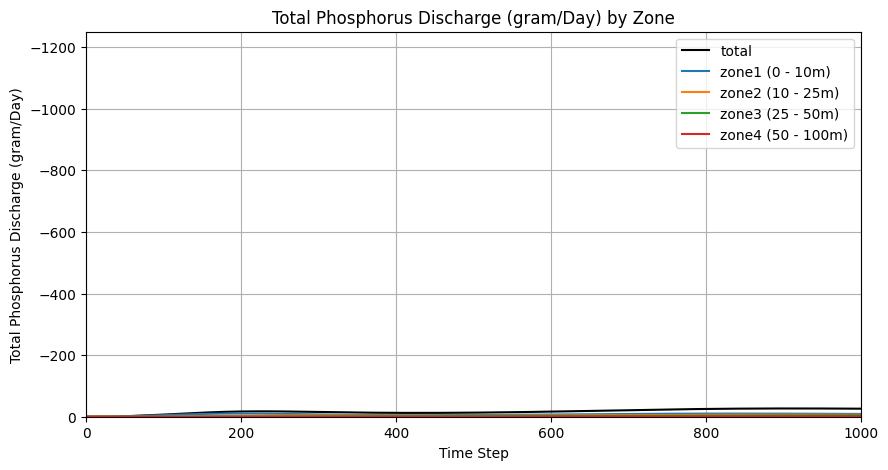

In [16]:
def discharge_by_distance_per_timestep(start_distance=1600, end_distance=1610):
    # Convert distances to row indices
    start_row = int(start_distance / delr)
    end_row = int(end_distance / delr)

    pDischargeArray = totalPhosphorusDischargePerRow[start_row]
    for row in range(start_row+1,end_row):
        pDischargeArray  = pDischargeArray + totalPhosphorusDischargePerRow[row]
    return pDischargeArray



pZone0= discharge_by_distance_per_timestep(1600,2200)

pZone1= discharge_by_distance_per_timestep(1600,1600)
pZone2= discharge_by_distance_per_timestep(1610,1625)
pZone3= discharge_by_distance_per_timestep(1625,1650)
pZone4= discharge_by_distance_per_timestep(1650,1700)

xs = np.arange(0,len(pZone1),1)

plt.plot(xs, pZone0/1000,c='k',label='total')
plt.plot(xs, pZone1/1000,label='zone1 (0 - 10m)')
plt.plot(xs, pZone2/1000,label='zone2 (10 - 25m)')
plt.plot(xs, pZone3/1000,label='zone3 (25 - 50m)')
plt.plot(xs, pZone4/1000,label='zone4 (50 - 100m)')

plt.title('Total Phosphorus Discharge (gram/Day) by Zone')  # Title
plt.xlabel('Time Step')  # X-axis label
plt.ylabel('Total Phosphorus Discharge (gram/Day)')  # Y-axis label
plt.legend()  # Legend to differentiate between the zones
plt.gca().invert_yaxis()
plt.legend()
plt.gcf().set_size_inches(10,5)
plt.ylim(0,-1250)
plt.xlim(0,1000)
plt.grid(True)  # Adding grid for better readability


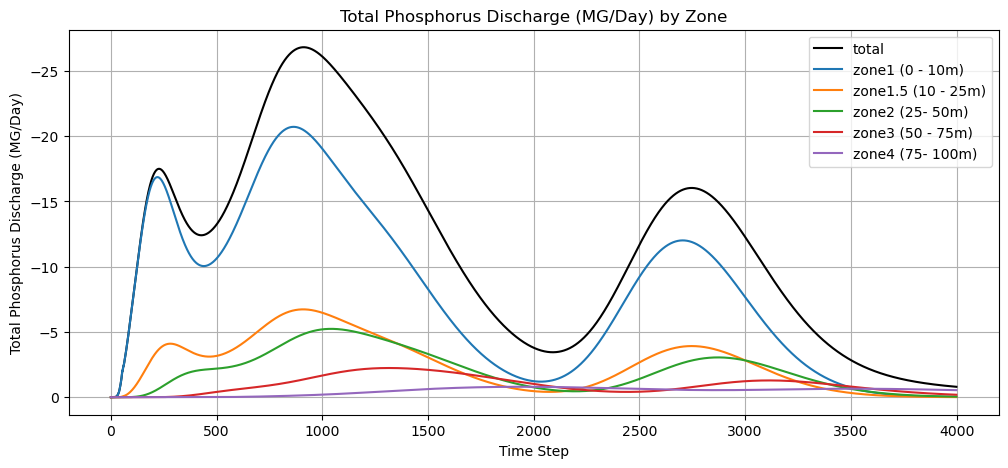

In [306]:
def discharge_by_distance_per_timestep(start_distance=1600, end_distance=1610):
    # Convert distances to row indices
    start_row = int(start_distance / delr)
    end_row = int(end_distance / delr)

    pDischargeArray = totalPhosphorusDischargePerRow[start_row]
    for row in range(start_row+1,end_row):
        pDischargeArray  = pDischargeArray + totalPhosphorusDischargePerRow[row]
    return pDischargeArray



pZone0= discharge_by_distance_per_timestep(1600,2200)

pZone1= discharge_by_distance_per_timestep(1600,1625)

pZone2= discharge_by_distance_per_timestep(1625,1650)
pZone3= discharge_by_distance_per_timestep(1650,1675)
pZone4= discharge_by_distance_per_timestep(1675,1800)

xs = np.arange(0,len(pZone1),1)

plt.plot(xs, pZone0/1000,c='k',label='total')
plt.plot(xs, pZone1/1000,label='zone1 (0 - 10m)')
plt.plot(xs, pZone1d5/1000,label='zone1.5 (10 - 25m)')
plt.plot(xs, pZone2/1000,label='zone2 (25- 50m)')
plt.plot(xs, pZone3/1000,label='zone3 (50 - 75m)')
plt.plot(xs, pZone4/1000,label='zone4 (75- 100m)')




plt.title('Total Phosphorus Discharge (MG/Day) by Zone')  # Title
plt.xlabel('Time Step')  # X-axis label
plt.ylabel('Total Phosphorus Discharge (MG/Day)')  # Y-axis label
plt.legend()  # Legend to differentiate between the zones
plt.gca().invert_yaxis()
plt.legend()
plt.gcf().set_size_inches(12,5)
plt.grid(True)  # Adding grid for better readability


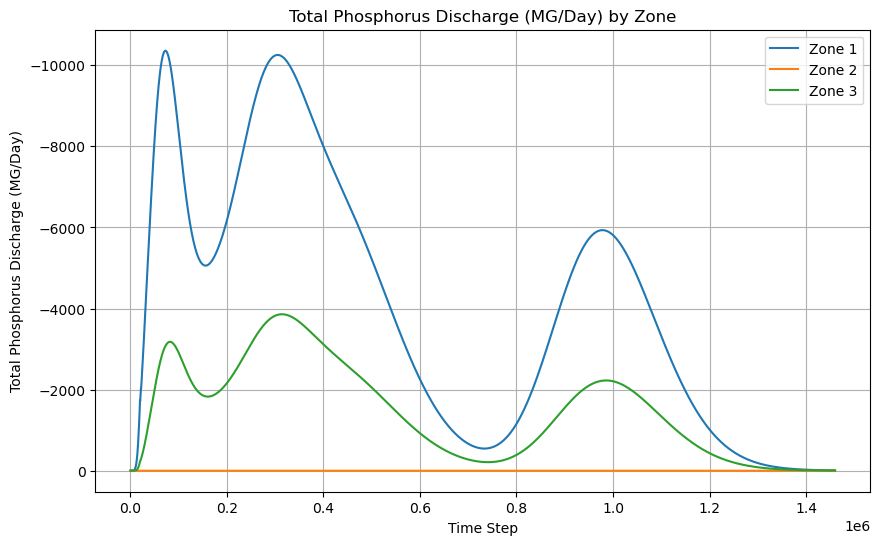

In [21]:

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(timeSteps, totalPhosphorusDischargeMGPerDay_zone1, label='Zone 1')  # Zone 1 plot
plt.plot(timeSteps, totalPhosphorusDischargeMGPerDay_zone2, label='Zone 2' ) # Zone 2 plot
plt.plot(timeSteps, totalPhosphorusDischargeMGPerDay_zone3, label='Zone 3')  # Zone 3 plot
#plt.plot(timeSteps, totalPhosphorusDischargeMGPerDay_zone4, label='Zone 4')  # Zone 3 plot
#plt.plot(timeSteps, totalPhosphorusDischargeMGPerDay_zone5, label='Zone 5')  # Zone 3 plot

plt.title('Total Phosphorus Discharge (MG/Day) by Zone')  # Title
plt.xlabel('Time Step')  # X-axis label
plt.ylabel('Total Phosphorus Discharge (MG/Day)')  # Y-axis label
plt.legend()  # Legend to differentiate between the zones
plt.gca().invert_yaxis()

plt.grid(True)  # Adding grid for better readability
plt.show()  # Display the plot


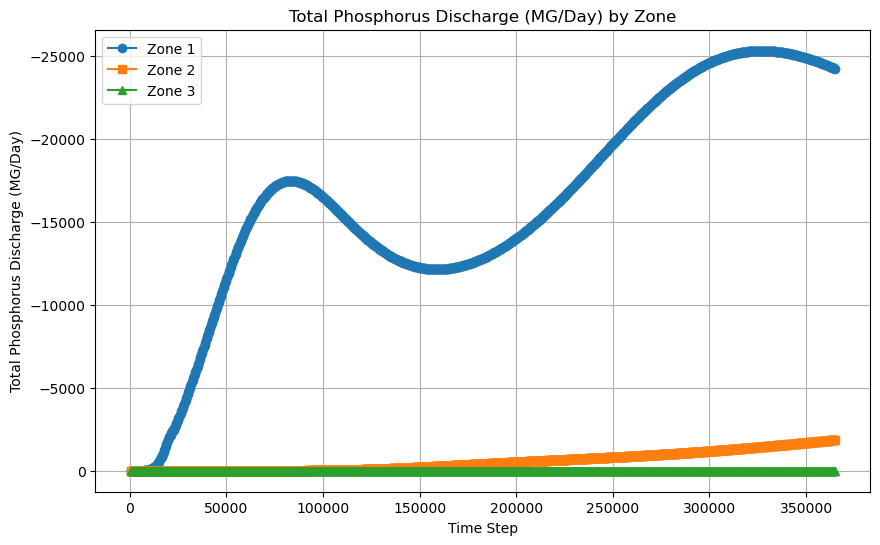

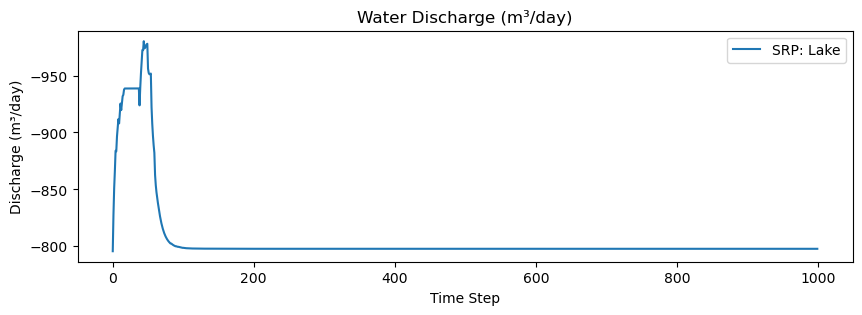

In [10]:
# Plot for water discharge
plt.plot(timeIndices, lakeDischargeM3PerDay, label='SRP: Lake')
plt.title('Water Discharge (m³/day)')
plt.xlabel('Time Step')
plt.ylabel('Discharge (m³/day)')
plt.gca().invert_yaxis()
plt.gcf().set_size_inches(10,3)
plt.legend()
plt.show()



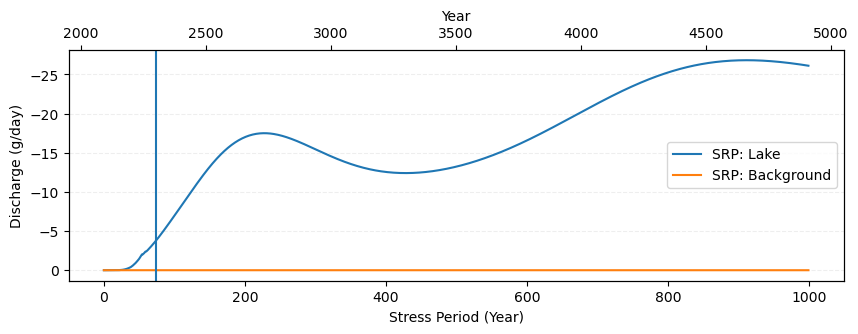

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming timeIndices, totalPhosphorusDischargeGPerDay, and lakeDischargeM3PerDay are defined

fig, ax1 = plt.subplots()
# Plot for Total Phosphorus Discharge
ax1.plot(timeIndices, totalPhosphorusDischargeGPerDay, label='SRP: Lake')
ax1.plot(timeIndices, np.array(lakeDischargeM3PerDay)*0.01/1000, label='SRP: Background')
#ax1.set_title('SRP Discharge (g P/day)')
ax1.set_xlabel('Stress Period (Year)')
ax1.set_ylabel('Discharge (g/day)')
ax1.invert_yaxis()
fig.set_size_inches(10,3)
plt.axvline(x=74)
# Add horizontal grid lines on ax1
ax1.grid(axis='y',color='#EEEEEE',linestyle='dashed')

# Create a secondary x-axis
ax2 = ax1.twiny()
# Set the limits for the new x-axis
ax2.set_xlim(1950, 5050)
# Optionally, set the label for the new x-axis
ax2.set_xlabel('Year')

# Display the legend on ax1
ax1.legend()

plt.show()


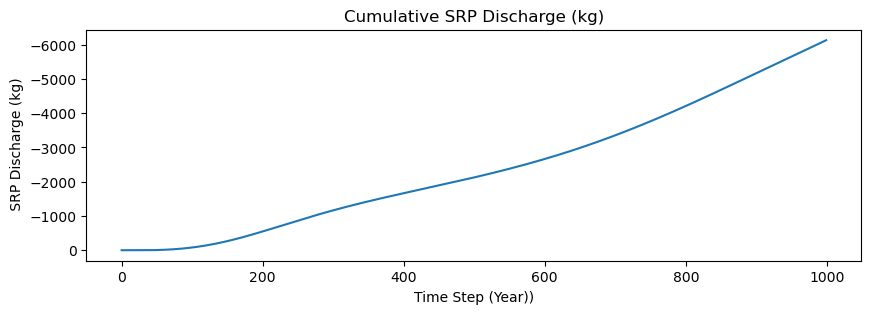

In [12]:
ys = np.cumsum(totalPhosphorusDischargeGPerDay*365/1000)
xs = range(0,len(ys))
plt.gca().invert_yaxis()
plt.title('Cumulative SRP Discharge (kg)')
plt.xlabel('Time Step (Year))')
plt.ylabel(' SRP Discharge (kg)')
plt.gcf().set_size_inches(10,3)
plt.plot(xs,ys)

## aqueous and solid phase

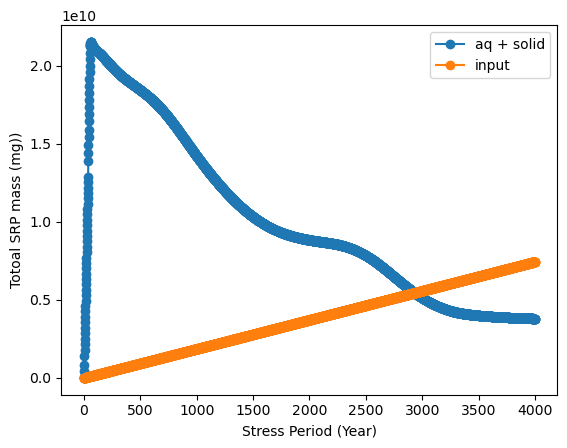

In [132]:
### SLOW ### SLOW ### SLOW

cmass_aq =[]
cmass_in = []
cmass_solid = []
kpers = []
ucnobj_aq = ucnobj
ucnobj_solid =  ucnobj_s
for kper in range(nper):

    # Read the concentration data from the UCN file
    if kper==0:
        source_mass = 0
    else:
        source_mass += 365*0.51*5000*2
    
    conc_array = ucnobj_aq.get_data(kstpkper=(0, kper))# (time step, stress period)
    conc_array[np.where(conc_array==1e30)] = 0
    conc_array[np.where(ibound!=1)] = 0
    c_aq = conc_array[np.where(conc_array>0.11)].sum()
    mass_aq = c_aq*delr*delc*layer_thickness* 0.25

    conc_array = ucnobj_solid.get_data(kstpkper=(0, kper))# (time step, stress period)
    conc_array[np.where(conc_array==1e30)] = 0
    conc_array[np.where(ibound!=1)] = 0
    c_solid = conc_array[np.where(conc_array>1e-7)].sum()
    mass_solid = c_solid*delr*delc*layer_thickness * 1.65E+09

    cmass_in.append(source_mass)
    cmass_aq.append(mass_aq)
    cmass_solid.append(mass_solid)
    kpers.append(kper)

ys = np.array(cmass_aq)
ys2 = np.array(cmass_in)
ys3 = np.array(cmass_solid)
ys4 = np.array(ys+ys3)
xs = kpers



plt.ylabel('Totoal SRP mass (mg))')
#plt.xticks(np.linspace(0,nper,5))
plt.xlabel('Stress Period (Year)')
#plt.title('mass_flux (input - output): {} '.format(cmass_in[-1] - cmass[-1]))
plt.plot(xs,ys4,marker='o',label='aq + solid')
plt.plot(xs,ys2,marker='o',label= 'input')
plt.legend()
plt.savefig(Path(model_ws)/'_output' /'mass.png')


SRPMassInSystem_x = xs
SRPMassInSystem_y = ys4
SRPMassInSystem_aq_y = ys
SRPMassInSystem_s_y = ys3

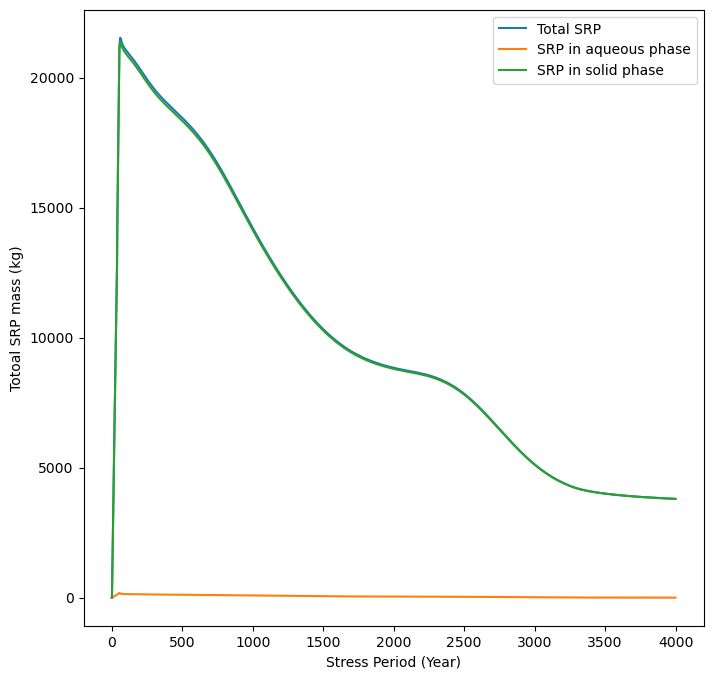

In [135]:
plt.ylabel('Totoal SRP mass (kg)')
#plt.xticks(np.linspace(0,nper,5))
plt.xlabel('Stress Period (Year)')
#plt.title('mass_flux (input - output): {} '.format(cmass_in[-1] - cmass[-1]))
plt.plot(SRPMassInSystem_x,SRPMassInSystem_y/1000000,label='Total SRP')
plt.plot(SRPMassInSystem_x,SRPMassInSystem_aq_y/1000000,label='SRP in aqueous phase')
plt.plot(SRPMassInSystem_x,SRPMassInSystem_s_y/1000000,label='SRP in solid phase')

plt.legend()
plt.gcf().set_size_inches(8,8)
plt.savefig(Path(model_ws)/'_output' /'mass.png')

(0.0, 4000.0)

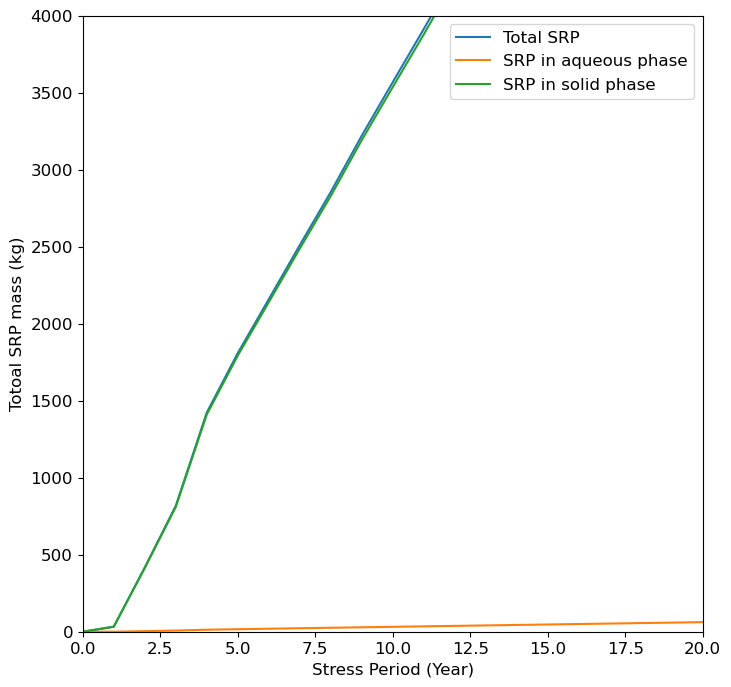

In [178]:
plt.ylabel('Totoal SRP mass (kg)')
#plt.xticks(np.linspace(0,nper,5))
plt.xlabel('Stress Period (Year)')
#plt.title('mass_flux (input - output): {} '.format(cmass_in[-1] - cmass[-1]))
plt.plot(SRPMassInSystem_x,SRPMassInSystem_y/1000000,label='Total SRP')
plt.plot(SRPMassInSystem_x,SRPMassInSystem_aq_y/1000000,label='SRP in aqueous phase')
plt.plot(SRPMassInSystem_x,SRPMassInSystem_s_y/1000000,label='SRP in solid phase')

plt.legend()
plt.gcf().set_size_inches(8,8)
plt.xlim(0,20)
plt.ylim(0,4000)
#plt.savefig(Path(model_ws)/'_output' /'mass.png')

In [ ]:
cmass =[]
cmass_in = []
kpers = []
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001S.UCN')
for kper in range(nper):

    # Read the concentration data from the UCN file
    if kper==0:
        source_mass = 0
    else:
        source_mass += 365*0.51*5000*2
    
    concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)
    concentration_array[np.where(concentration_array==1e30)] = 0
    concentration_array[np.where(ibound!=1)] = 0

    csum = concentration_array[np.where(concentration_array>1e-6)].sum()
    mass = csum*delr*delc*layer_thickness * 1.65E+09

    cmass_in.append(source_mass)
    cmass.append(mass)
    kpers.append(kper)

ys = np.array(cmass)/1000/1000
ys2 = np.array(cmass_in)/1000/1000
xs = kpers



plt.ylabel('Totoal SRP mass (mg))')
#plt.xticks(np.linspace(0,nper,5))
plt.xlabel('Stress Period (Year)')
plt.title('mass_flux (input - output): {} '.format(cmass_in[-1] - cmass[-1]))
plt.plot(xs,ys,marker='o',label='output')
plt.plot(xs,ys2,marker='o',label= 'input')
plt.legend()
plt.savefig(Path(model_ws)/'_output' /'mass_sorbed.png')

# MapView

In [116]:
open_file(model_ws)

In [118]:
open_file(model_ws)

In [277]:
import os
import flopy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from pathlib import Path

from PIL import Image

# Assuming 'model_ws' and 'model' variables are defined and valid
# ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
output_folder = Path(model_ws) / '_output' / 'linear_concentration_maps'

output_folder.mkdir(parents=True, exist_ok=True)

model_begin_year = 1950
times = ucnobj.get_times()
image_files = []


In [ ]:
for kper, totim in enumerate(target_times):

    conc = ucnobj.get_data(totim=totim)
    conc[np.where(conc == 1e30)] = 0
    conc_sum = np.sum(conc, axis=0)
    conc_sum = conc_sum * (delr*delc*layer_thickness)

    fig, ax = plt.subplots(figsize=(10, 10))
    mapview = flopy.plot.PlotMapView(model=model)
    mapview.plot_array(conc_sum, vmin=0, vmax=60000, ax=ax,cmap=plt.cm.coolwarm)
    plt.axhline(y=2200-shoreline_distance)
    plt.gca().invert_yaxis()
    

    sm = ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=0, vmax=10000))
    sm.set_array([])
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(sm, cax=cax, label='SRP Mass (mg)')
    year = totim/365 + model_begin_year +1
    year = round(year,1)
    #plt.title(f'Concentration Map - Year {year}', pad=20)
    
    output_file = output_folder / f'map_year_{year}.png'
    plt.savefig(output_file, bbox_inches='tight',dpi=300)
    plt.close()
    image_files.append(output_file)

print(f'All concentration maps saved to {output_folder}')

In [310]:
image_files = []
for kper, totim in enumerate(target_times):

    conc = ucnobj.get_data(totim=totim)
    conc[np.where(conc == 1e30)] = 0
    conc_sum = np.sum(conc, axis=0)
    conc_sum = conc_sum * (delr*delc*layer_thickness)

    fig, ax = plt.subplots(figsize=(10, 10))
    mapview = flopy.plot.PlotMapView(model=model)
    mapview.plot_array(conc_sum, vmin=0, vmax=60000, ax=ax,cmap=plt.cm.coolwarm)
    plt.axhline(y=2200-shoreline_distance)
    plt.gca().invert_yaxis()
    

    sm = ScalarMappable(cmap=plt.cm.coolwarm, norm=plt.Normalize(vmin=0, vmax=10000))
    sm.set_array([])
    cax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = plt.colorbar(sm, cax=cax, label='SRP Mass (mg)')
    year = totim/365 + model_begin_year +1
    year = round(year,1)
    #plt.title(f'Concentration Map - Year {year}', pad=20)
    
    output_file = output_folder / f'map_year_{year}.png'
    plt.savefig(output_file, bbox_inches='tight',dpi=300)
    plt.close()
    image_files.append(output_file)

print(f'All concentration maps saved to {output_folder}')

All concentration maps saved to /Volumes/Expansion/mf/_T0212235115__Thin_Map/_output/linear_concentration_maps


## Figure

In [318]:
target_values = [365*10, 365*50, 365*100,365*400,365*700,365*1000,365*2000,365*4000]
# Find indices of target values in the list
indices = [min(range(len(times)), key=lambda i: abs(times[i] - target)) for target in target_values]

target_times= [times[index] for index in indices]
target_values

image_files = []

for kper, totim in enumerate(target_times):
    print (kper)

0
1
2
3
4
5
6
7


In [304]:
# Target values you want to find in the list

target_values = [365*10, 365*50, 365*100,365*400,365*700,365*1000,365*2000,365*4000]
# Find indices of target values in the list
indices = [min(range(len(times)), key=lambda i: abs(times[i] - target)) for target in target_values]

target_times= [times[index] for index in indices]
target_values

image_files = []

for kper, totim in enumerate(target_times):

    conc = ucnobj.get_data(totim=totim)
    conc[np.where(conc == 1e30)] = 0
    conc_sum = np.sum(conc, axis=0)
    conc_sum_kg = conc_sum*delr*delc*layer_thickness/1000

    fig, (ax, ax2) = plt.subplots(1, 2, figsize=(4, 3.5), gridspec_kw={'width_ratios': [3.8, 1]})
    
    # First subplot with the concentration map
    mapview = flopy.plot.PlotMapView(model=model, ax=ax)
    mapview.plot_array(conc_sum_kg, vmin=0, vmax=10000/160,cmap=plt.cm.coolwarm)
    ax.axhline(y=2200-shoreline_distance,c='white',linestyle='dashed')
    ax.invert_yaxis()
    #ax.set_ylabel('Cross-shore Distance (m) ')
    ax.set_xlabel('Along-shore Distance (m) ')
    ax.set_yticks(np.arange(0,2200,200))
    ax.set_yticklabels(['' for _ in ax.get_yticks()])
    

    sm = ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=0, vmax=10000/160))
    sm.set_array([])

    year = totim/365 + model_begin_year + 1
    year = round(year, 1)

    conc_sum_sum = np.sum(conc_sum,axis=1)
    mass_sum_sum_g = conc_sum_sum*delr*delc*layer_thickness/1000
    ys = np.linspace(0,2200,len(mass_sum_sum_g))[::-1]
    xs = mass_sum_sum_g
    ax2.plot(xs,ys,label = 'aqueous phase',c='r')
    ax2.invert_yaxis()

    ax2.set_xlabel('SRP Mass (g)', color='red')  # Set x-axis label to red
    ax2.set_xlim(-1000, 8000)

    # Set x-axis ticks and tick labels to red
    ax2.set_xticks([0, 4000])
    for label in ax2.get_xticklabels():
        label.set_color('red')

    ax2.set_ylim(2200, 0)
    ax2.set_yticks([])  # No y-axis ticks

    # Set y-axis grid
    ax2.yaxis.grid(True)

    fig.tight_layout(pad=1.0)
    plt.subplots_adjust(wspace=0) 
    

    output_file = output_folder / f'concentration_map_year_{year}.png'
    plt.savefig(output_file, bbox_inches='tight', dpi=300)
    plt.close()
    image_files.append(output_file)


from PIL import Image

# Assuming 'image_files' is a list of 8 image file paths
if len(image_files) == 8:
    # Load all images
    images = [Image.open(x) for x in image_files]

    # Assuming all images are of the same size, get width and height of the first image
    width, height = images[0].size

    # Calculate total width and total height for the 4x2 grid
    total_width = width * 2
    total_height = height * 4

    # Create a new blank image with the calculated size
    new_im = Image.new('RGB', (total_width, total_height))

    # Paste images into the new image
    y_offset = 0
    for i in range(4):  # Four rows
        x_offset = 0
        for j in range(2):  # Two columns
            # Calculate the index of the current image
            index = i * 2 + j
            # Paste the current image into the new image
            new_im.paste(images[index], (x_offset, y_offset))
            # Move to the next column
            x_offset += width
        # Move to the next row
        y_offset += height

    # Save the new mosaic image
    mosaic_file = output_folder / 'concentration_maps_mosaic_4x2.png'
    new_im.save(mosaic_file)
else:
    print("The number of generated images does not match the expected 4x2 grid layout.")


### Video

In [ ]:
import cv2

# Parameters for video creation
frame_duration = 0.1  # Duration of each image in the video
fps = int(1 / frame_duration)  # Frames per second
video_output = output_folder / 'concentration_video.mp4'

# Read the first image to determine the video resolution
frame = cv2.imread(str(image_files[0]))
height, width, layers = frame.shape

size = (width, height)

# Initialize video writer
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change the codec if needed
video = cv2.VideoWriter(str(video_output), fourcc, fps, size)

# Add images to video
for image_file in image_files:
    frame = cv2.imread(str(image_file))
    if frame.shape[1] != width or frame.shape[0] != height:
        raise ValueError(f"Image {image_file} has different size. All images must have the same dimensions.")
    video.write(frame)


# Release the video writer
video.release()
print(f"Video saved as {video_output}")

In [ ]:
ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
times = ucnobj.get_times()
conc = ucnobj.get_data(totim=times[-10])  # get the concentration data for the last time step
conc[np.where(conc==1e30)] = 0
conc_sum = np.sum(conc, axis=0)
mapview = flopy.plot.PlotMapView(model=model)
fig = mapview.plot_array(conc_sum,vmin=0,vmax=10000)
plt.colorbar(fig)
plt.axhline(y=2200-1700)
plt.gca().invert_yaxis()
plt.xlim(146*5-100,146*5+100)
plt.axvline(x=146*5,c='k')
#plt.ylim(900,450)
plt.gcf().set_size_inches(10,10)
plt.show()

In [ ]:
nper = model.dis.nper
ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws) / 'MT3D001.UCN')
#for kper in range(nper)[::5]:
for kper in [3,17,59]:


    ucnobj = flopy.utils.binaryfile.UcnFile(Path(model_ws)/'MT3D001.UCN')
    times = ucnobj.get_times()
    conc = ucnobj.get_data(kstpkper=(0, kper))
    conc[np.where(conc==1e30)] = 0
    conc_sum = np.sum(conc, axis=0)
    conc_sum = np.flipud(conc_sum)
    mapview = flopy.plot.PlotMapView(model=model)
    fig = mapview.plot_array(conc_sum, cmap='coolwarm', vmin=0, vmax=800)
    #plt.show()

    plt.title('kper:{:02}'.format(kper))
    plt.xlim(650,850)
    plt.ylim(1550,1750)
    plt.colorbar(fig)
    plt.axhline(1700,c='k',linestyle = 'dashed')
    plt.axhline(1700-70,c='r')
    plt.axhline(1700-70+20,c='k')
    plt.axhline(1700-70+40,c='k')
    plt.axhline(1700-70+60,c='k')

    plt.savefig(Path(model_ws)/'_output'/'map_conc_{:02}'.format(kper))    
    
    plt.clf()

In [ ]:
open_file(model_ws)

In [ ]:
kper = 18
lay = int(nlay/2)

fig = plt.figure(figsize=(15, 5))
mapview = flopy.plot.PlotMapView(model=model, layer=lay)
ucnobj = flopy.utils.binaryfile.UcnFile(model_ws + '/MT3D001.UCN')
concentration_array = ucnobj.get_data(kstpkper=(0, kper))# (time step, stress period)

ibound = model.bas6.ibound.array
mask = ((ibound== 0)|(concentration_array>=1e30))
masked_conc_data = np.ma.masked_where(mask, concentration_array)

cs = mapview.plot_array(masked_conc_data, cmap='coolwarm', vmin=0, vmax=900)
plt.colorbar(cs)

# Show the plot
plt.gcf().set_size_inches(12,12)
plt.show()

array([[[[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         ...,
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013]]],


       [[[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         ...,
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013]]],


       [[[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
         [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.0

In [44]:
model.rch.rech.array.shape

(1000, 1, 440, 440)

# Septic Timeline

## read Septic data

In [8]:
mf = model

In [11]:
shoreline_distance =1600
septic_gw_flux=0.51

In [12]:
import pandas as pd

model_begin_year = 1950
def calculate_year_septic_start(df):
    # Ensure the DataFrame is sorted by 'Year'
    df = df.sort_values('Year').reset_index(drop=True)
    
    # Get the unique years and sort them
    unique_years = sorted(df['Year'].unique())
    
    # Initialize the "Year_Septic_Start" list
    year_septic_start = []
    
    # Iterate through the DataFrame rows
    for current_year in df['Year']:
        # Find the index of the current_year in the unique_years list
        current_index = unique_years.index(current_year)
        
        # Determine the previous year (if it's not the first year)
        if current_index == 0:
            #previous_year = 1950  # If it's the first unique year, use 1950
            year_septic_start.append(model_begin_year )
        else:
            previous_year = unique_years[current_index - 1]  # Get the previous unique year
        
        # Calculate the "Year_Septic_Start"
            year_septic_start.append((current_year + previous_year) // 2)
    
    # Add the "Year_Septic_Start" as a new column in the DataFrame
    df['Year_Septic_Start'] = year_septic_start
    return df

df = pd.read_csv("wasaga septics placement/septics_transformed.csv")
df = df[~df['Year End'].isna()]
df['Year End'] =df['Year End'].astype(int)
df = calculate_year_septic_start(df)
df['Year_Septic_End'] = df['Sewer_Installation_Period'].apply(lambda x: (int(x.split('-')[1]) + int(x.split('-')[0]))//2)
# Assuming necessary variables (shoreline_distance, delr, ncol, nrow, nlay, ibound) are defined
start_dis_1 = shoreline_distance - 150
end_dis_1 = shoreline_distance - 60
import numpy as np
import flopy  # Assuming flopy is already installed and imported

# Assuming nrow, ncol, delr, delc, mf are defined earlier in your code
# Define start_dist, end_dist, and exclude_range
start_dist = start_dis_1 -100  # Define start distance for exclusion (e.g., 1000 meters)
end_dist = end_dis_1    # Define end distance for exclusion (e.g., 2000 meters)
exclude_range = False  # Set to True to exclude, False to include

# Convert distances to row indices
start_row_index = int(start_dist / delr)
end_row_index = int(end_dist / delr)

# Initialize the recharge dictionary
rch_dict = {0: np.full((nrow, ncol), 0.00013, dtype=float)}  # Initial background recharge rate
# for kper in range(nper-1):
#     rch_dict = {kper: np.full((nrow, ncol), 0.00013, dtype=float)} 

# Loop through the DataFrame to update rch_dict
for index, row in df.iterrows():
    easting = row['Wasaga Easting']
    northing = row['Wasaga Northing']
    start_year = row['Year_Septic_Start']
    end_year = row['Year_Septic_End']

    # Calculate the indices
    row_index = int(northing / delr)
    col_index = int(easting / delc)

    # Check if row index is within the exclusion range and if exclusion is enabled
    if exclude_range and start_row_index <= row_index <= end_row_index:
        continue  # Skip updating for this row index

    # Calculate the range of years for each septic source
    start_key = start_year - model_begin_year + 1
    end_key = end_year - model_begin_year  + 1

    # Loop through each year for the septic source
    for year_key in range(start_key, end_key + 1):
        # Check if the key exists in the dictionary, if not, create a new array with background recharge
        if year_key not in rch_dict:
            rch_dict[year_key] = np.full((nrow, ncol), 0.00013, dtype=float)

        # Update the recharge rate at the septic location
        rch_dict[year_key][row_index, col_index] = septic_gw_flux / delr / delc
    
    # Ensure the septic is turned off after its end year
    if end_key + 1 not in rch_dict:
        rch_dict[end_key + 1] = np.full((nrow, ncol), 0.00013, dtype=float)

    # Set the recharge rate back to the background rate after the septic system's active period
    rch_dict[end_key + 1][row_index, col_index] = 0.00013

# Create the ModflowRch object
rch = flopy.modflow.ModflowRch(model=mf, rech=rch_dict)

rch_dict

{0: array([[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        ...,
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013]]),
 1: array([[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        ...,
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013]]),
 2: array([[0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.00013],
        [0.00013, 0.00013, 0.00013, ..., 0.00013, 0.00013, 0.000

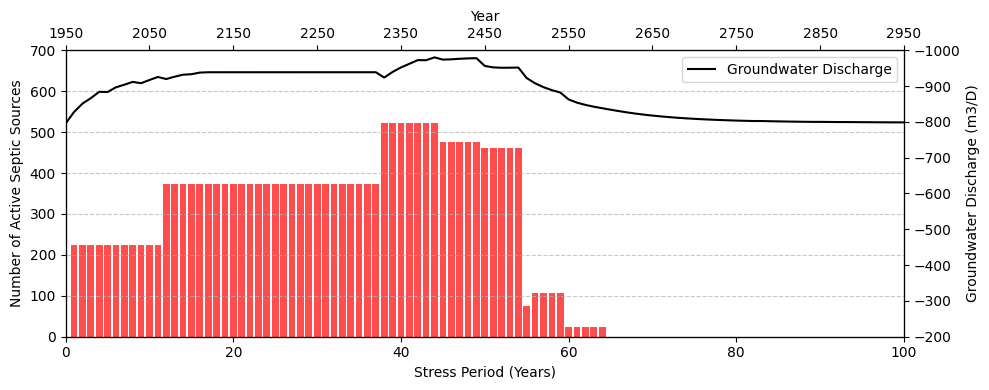

In [13]:
septic_gw_flux = 0.51
# Assuming rch_dict, delr, and delc are defined elsewhere and model_begin_year is provided

# Calculate and plot in a compact form
kpers, active_septics = zip(*sorted((year_key, np.sum(rech >= septic_gw_flux / delr / delc)) for year_key, rech in rch_dict.items()))
active_septics = [value - 150 if 1 <= index <= 11 else value for index, value in enumerate(active_septics)]


fig, ax1 = plt.subplots(figsize=(10, 4))
bars = ax1.bar(kpers, active_septics, color='red', alpha=0.7,label='Number of Active Septic Systems')

ax1.set(xlabel='Stress Period (Years)', ylabel='Number of Active Septic Sources', title=None)
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.set_xlim(-4,nper)
ax1.set_ylim(0,700)

# Adding secondary x-axis on top
ax2 = ax1.twiny()  # Create a twin Axes sharing the y-axis

# Decide on the number of ticks: for example, one tick every 5 ticks from the original x-axis
kpers=range(1001)
tick_spacing = 100
selected_ticks = kpers[::tick_spacing] 
selected_labels = [str(x + model_begin_year) for x in selected_ticks]



ax2.set_xticks(selected_ticks)
ax2.set_xticklabels(selected_labels)
ax2.set_xlabel('Year')  # Set label for the secondary x-axis


ax3 = ax1.twinx()

ax3.plot(timeIndices, lakeDischargeM3PerDay,color='k',label='Groundwater Discharge')

ax3.invert_yaxis()
ax3.set_ylim(-200,-1000)
plt.xlim(0,100)
ax3.set(ylabel='Groundwater Discharge (m3/D)')
plt.legend()


#plt.xlim(0,1000)
plt.tight_layout()
plt.show()



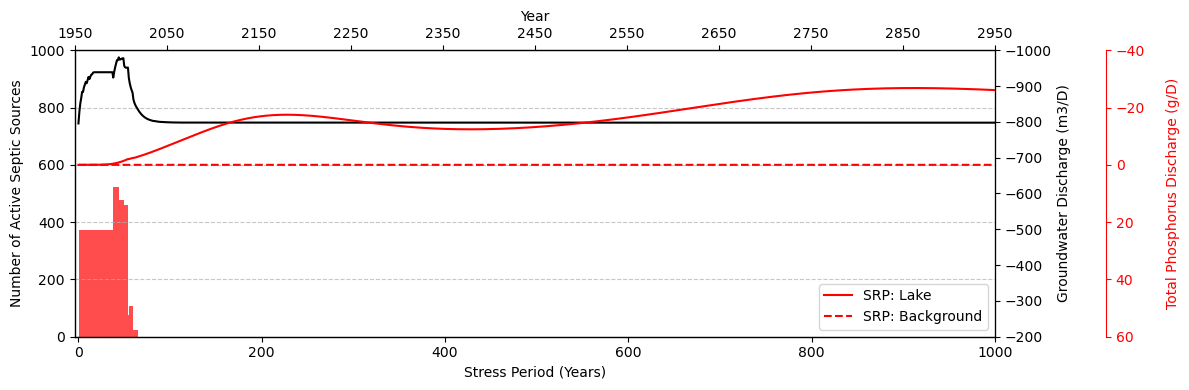

In [115]:

septic_gw_flux = 0.51  # Threshold for septic groundwater flux

# Compact calculation of active septics
kpers, active_septics = zip(*sorted((y, np.sum(r >= septic_gw_flux / delr / delc)) for y, r in rch_dict.items()))

fig, ax1 = plt.subplots(figsize=(12, 4))
bars = ax1.bar(kpers, active_septics, color='red', alpha=0.7, width=1)  # Adjusted bar width here
ax1.set(xlabel='Stress Period (Years)', ylabel='Number of Active Septic Sources', xlim=(-4, nper), ylim=(0, 1000))
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# Secondary x-axis for years
ax2 = ax1.twiny()
selected_ticks = range(0, 1001, 100)  # Assuming 1000 is the max value of kpers for this example
ax2.set_xticks(selected_ticks)
ax2.set_xticklabels([str(x + model_begin_year) for x in selected_ticks])
ax2.set_xlabel('Year')

# Twin axes for groundwater discharge
ax3 = ax1.twinx()
ax3.plot(timeIndices, lakeDischargeM3PerDay, color='k')
ax3.set_ylim(-1000, -200)
ax3.set_ylabel('Groundwater Discharge (m3/D)')
ax3.invert_yaxis()

# Twin axes for phosphorus discharge with red axis labels and tick labels
ax4 = ax1.twinx()
ax4.spines["right"].set_position(("outward", 80))
phosphorus_plots = [
    ax4.plot(timeIndices, totalPhosphorusDischargeGPerDay, label='SRP: Lake', c='r'),
    ax4.plot(timeIndices, np.array(lakeDischargeM3PerDay)*0.01/1000, label='SRP: Background', c='r', linestyle='dashed')
]
ax4.set_ylim(-40, 60)
ax4.set_ylabel('Total Phosphorus Discharge (g/D)', color='r', labelpad=15)
ax4.tick_params(axis='y', colors='red')  # Set tick label colors to red
ax4.spines["right"].set_color('red')
ax4.invert_yaxis()

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()


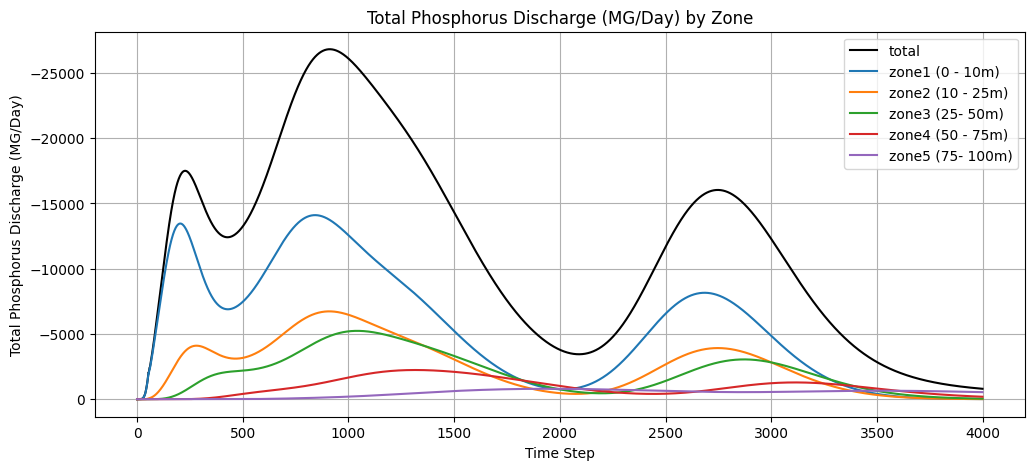

In [19]:

pZone0= discharge_by_distance_per_timestep(1600,2200)

pZone1= discharge_by_distance_per_timestep(1600,1610)
pZone2= discharge_by_distance_per_timestep(1610,1625)
pZone3= discharge_by_distance_per_timestep(1625,1650)
pZone4= discharge_by_distance_per_timestep(1650,1675)
pZone5= discharge_by_distance_per_timestep(1675,1800)

xs = np.arange(0,len(pZone1),1)

plt.plot(xs, pZone0,c='k',label='total')
plt.plot(xs, pZone1,label='zone1 (0 - 10m)')
plt.plot(xs, pZone2,label='zone2 (10 - 25m)')
plt.plot(xs, pZone3,label='zone3 (25- 50m)')
plt.plot(xs, pZone4,label='zone4 (50 - 75m)')
plt.plot(xs, pZone5,label='zone5 (75- 100m)')




plt.title('Total Phosphorus Discharge (MG/Day) by Zone')  # Title
plt.xlabel('Time Step')  # X-axis label
plt.ylabel('Total Phosphorus Discharge (MG/Day)')  # Y-axis label
plt.legend()  # Legend to differentiate between the zones
plt.gca().invert_yaxis()
plt.legend()
plt.gcf().set_size_inches(12,5)
plt.grid(True)  # Adding grid for better readability


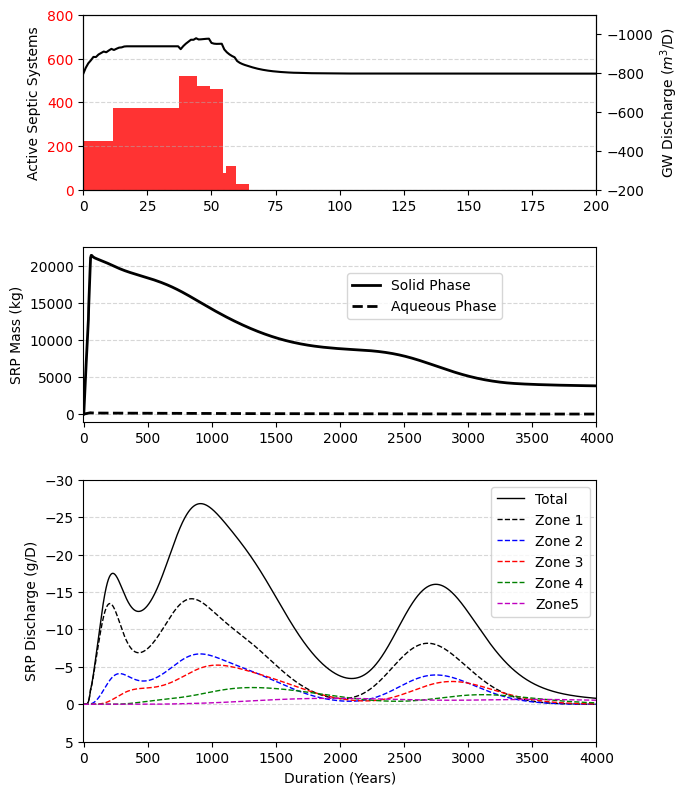

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path



def plot_active_septics(ax, periods, actives):
    ax.bar(periods, actives, color='r', alpha=0.8, width=1)
    ax.set(ylabel='Active Septic Systems', xlim=(-4, nper), ylim=(0, 800))
    ax.tick_params(axis='y', labelcolor='r')
    #ax.tick_params(axis='x', labelbottom=False)  # Hide x-axis tick labels
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_xlim(0,200)

def plot_secondary_x_axis(ax, start_year):
    selected_ticks = range(0, 1001, 100)
    ax.set_xticks(selected_ticks)
    ax.set_xticklabels([str(x + start_year) for x in selected_ticks])
    ax.set_xlabel('Year')

def plot_groundwater_discharge(ax, time_indices, discharge):
    ax.plot(time_indices, discharge, color='k')
    ax.set_ylim(-1100, -200)
    ax.set_ylabel('GW Discharge ($m^3$/D)', color='k')
    ax.invert_yaxis()
    #ax.tick_params(axis='x', labelbottom=False)  # Hide x-axis tick labels

def plot_phosphorus_discharge(ax, time_indices, discharges, labels, colors, line_styles):
    for discharge, label, color, line_style in zip(discharges, labels, colors, line_styles):
        ax.plot(time_indices, np.array(discharge)/1000, label=label, color=color, linestyle=line_style, linewidth=1)
    ax.set(ylim=(-30, 5), xlim=(-4, nper))
    ax.set_ylabel('SRP Discharge (g/D)')
    ax.invert_yaxis()
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend(loc='upper right')
    #ax.tick_params(axis='x', labelbottom=False)  # Hide x-axis tick labels
    ax.set_xlabel('Duration (Years)')

def plot_srp_mass(ax, x, aq_y, s_y, line_styles):
    ax.plot(x, np.array(s_y)/1e6, label='Solid Phase', color='k', linewidth=2, linestyle=line_styles[0])
    ax.plot(x, np.array(aq_y)/1e6, label='Aqueous Phase', color='k', linewidth=2, linestyle=line_styles[1])
    
    ax.set(xlim=(-4, nper))
    ax.set_ylabel('SRP Mass (kg)')
    
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.legend( bbox_to_anchor=(0.5, 0.55))  # Move the legend slightly down

plt.rcParams.update({'font.size': 10}) 
septic_gw_flux = 0.51  # Threshold for septic groundwater flux
kpers, active_septics = zip(*sorted((y, np.sum(r >= septic_gw_flux / delr / delc)) for y, r in rch_dict.items()))
active_septics = [value - 150 if 1 <= index <= 11 else value for index, value in enumerate(active_septics)]

fig, axs = plt.subplots(3, 1, figsize=(7, 8), gridspec_kw={'height_ratios': [1, 1, 1.5]})
plt.subplots_adjust(hspace=2) 

plot_active_septics(axs[0], kpers, active_septics)
#plot_secondary_x_axis(axs[1].twiny(), model_begin_year)
plot_groundwater_discharge(axs[0].twinx(), timeIndices, lakeDischargeM3PerDay)

line_styles = ['-', '--', '--','--','--','--']
phosphorus_zones = [pZone0, pZone1, pZone2,pZone3,pZone4,pZone5]
plot_phosphorus_discharge(axs[2], timeIndices, phosphorus_zones, ['Total', 'Zone 1', 'Zone 2','Zone 3','Zone 4','Zone5'], ['k', 'k', 'b','r','g','m'], line_styles)

plot_srp_mass(axs[1], SRPMassInSystem_x, SRPMassInSystem_aq_y, SRPMassInSystem_s_y, line_styles=line_styles)


plt.tight_layout()

plt.savefig(Path(model_ws) / '_output' / 'mass.png')
plt.show()


array([ -3.66365234,  -3.81259445,  -3.92213458, ..., -11.83923772,
       -11.76625858, -11.69390025])

# Pickle Save 

In [275]:
import pickle
# Pack the variables into a dictionary for convenience
data_to_save = {
    "totalPhosphorusDischargeMGPerDay": totalPhosphorusDischargeMGPerDay,
    "lakeDischargeM3PerDay": lakeDischargeM3PerDay,
    "timeIndices": timeIndices,
    "totalPhosphorusDischargeGPerDay": totalPhosphorusDischargeGPerDay,
    "SRPMassInSystem_x" :SRPMassInSystem_x,
    "SRPMassInSystem_y" : SRPMassInSystem_y,
    "SRPMassInSystem_aq_y": SRPMassInSystem_aq_y,
    "SRPMassInSystem_s_y":SRPMassInSystem_s_y,
    "totalPhosphorusDischargeMGPerDay_zoneTotal":totalPhosphorusDischargeMGPerDay_zoneTotal,
    "totalPhosphorusDischargePerRow": totalPhosphorusDischargePerRow
}

# Specify the filename for the saved data
filename = model_ws/'_output'/'saved_variables.pkl'

# Open a file in binary-write mode and save the dictionary using pickle
with open(filename, 'wb') as file:
    pickle.dump(data_to_save, file)